# Jupyter notebook to generate the data and plot Figures: 4, S6, S7 and S9 in "Heat extremes driven by amplification of phase-locked circumglobal waves forced by topography in an idealized atmospheric model" by B. Jimenez-Esteve, K. Kornhuber and D. I.V. Domeisen

Author: Bernat Jimenez-Esteve (ETH Zurich) Last update: October 2022

The notebook blocks need to be executed sequencially in order to be able to reproduce the same Figures as in the paper.

The netCDF files containing the processed model data can be downloaded from the following repository:

In [1]:
#load main modeules
import xarray as xr
import numpy as np

In [2]:
# this function computes the onset,end and duration of an event marked by 1s
def cal_onset_date(x):
    
    #difference of shifted arrays
    shift = np.array(x[1:]) - np.array(x[0:len(x)-1]).astype(int)
    onset = np.array(np.where(shift == 1)).astype(int).flatten() #transition form 0 to 1
    end = np.array(np.where(shift == -1)).astype(int).flatten() #transition form 1 to 0
    #check the first and last event
    if (len(end)==0 or len(onset)==0):
        duration = end
    else: 
        if (end[0]<=onset[0]):
            end = end[1:len(onset)+1]
        try:
            if (onset[len(onset)-1]>=end[len(end)-1]):
                onset = onset[0:len(onset)-1]
        except:
            pass
        duration = np.array(end - onset)
        
    return onset, end, duration

def filter_min_duration(x,min_dur):
    on,end,dur = cal_onset_date(x)
    x_new = np.copy(x)
    if(len(on)>=1):
        on_d = on[np.logical_not(np.isnan(xr.where(dur>=min_dur,np.nan, on)))].astype(int)
        end_d = end[np.logical_not(np.isnan(xr.where(dur>=min_dur,np.nan, end)))].astype(int)
        for k, onset in enumerate(on_d):
            x_new[onset:end_d[k]+1] = 0
    del(on,end,dur)
    return(x_new)      

# DATA

In [3]:
# the user would need to adapt this directory here:
root='data/wave_amplitudes/'
amp_0 = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_notopo.nc').amplitudes

wn, time = amp_0.wavenumber, amp_0.time
amp_mnt = xr.DataArray(coords=[[0,1,2,3],time, wn], dims=['sim','time','wn'])
phase_mnt = xr.DataArray(coords=[[0,1,2,3],time, wn], dims=['sim','time','wn'])

In [4]:
amp_mnt[0] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_notopo.nc').amplitudes
amp_mnt[1] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_4km_45N.nc').amplitudes
amp_mnt[2] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_8km_45N.nc').amplitudes
amp_mnt[3] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_8km_25N.nc').amplitudes

## Detection of high-amplitude events

In [5]:
#Indetify times where the 7d running mean is above the 1.5 SD threshold
#the code below does the work for all teh simulations contained in the amp_mnt array
thres_SD = 1.5 #SD
min_dur = 3   #days

thresh = amp_mnt.mean('time')+thres_SD*amp_mnt.std('time')

#put 1s when the amplitude is above the above calculated threshold
i_amp_event_mnt = xr.where(amp_mnt>thresh, 1, 0)

#require a persistence criteria of 3 days, similar to hw
#new arrays with the same dimensionality and coordinates
i_amp_event_persist = i_amp_event_mnt.copy(data=np.zeros(i_amp_event_mnt.shape)) #to have the same coordinates
 

# loop over sim, wavenumber 
for i, sim in enumerate(i_amp_event_mnt.sim):
    for j,wn in enumerate(i_amp_event_mnt.wn):
        i_amp_event_persist[i,:,j] = filter_min_duration(i_amp_event_mnt[i,:,j].values, min_dur)
        
print(i_amp_event_persist.mean('time').sel(wn=5)) #should be arround 8%

<xarray.DataArray (sim: 4)>
array([0.08143413, 0.08097091, 0.08226793, 0.0834723 ])
Coordinates:
  * sim      (sim) int64 0 1 2 3
    wn       int64 5


In [6]:
#this is the percentage of persistent days belonging to persistent events form the total
for wn in range(3,8):
    print(list(i_amp_event_persist.sel(sim=3,wn=wn)).count(1)/list(i_amp_event_mnt.sel(sim=3,wn=wn)).count(1))

0.9112627986348123
0.9497663551401869
0.9761646803900325
0.9573241061130334
0.8845291479820628


In [7]:
#calculate the onset, end dates and duration of each event
sim, wn = amp_mnt.sim, amp_mnt.wn

#define a new xarray
duration = xr.DataArray(coords=[np.arange(1,201),sim, wn], dims=['event','sim' , 'wn'])

#onset and end of the events
onset_dates = xr.DataArray(attrs = {'units' : 'days since 0001-01-04 00:00:00'},
                           coords=[np.arange(1,201),sim, wn],
                           dims=['event','sim' , 'wn'])

end_dates = xr.DataArray(attrs = {'units' : 'days since 0001-01-04 00:00:00'},
                         coords=[np.arange(1,201),sim, wn],
                         dims=['event','sim' , 'wn'])

# loop over sim, wavenumber 
for i, sim in enumerate(i_amp_event_mnt.sim):
    for j,wn in enumerate(i_amp_event_mnt.wn):
        tmp = cal_onset_date(i_amp_event_persist.sel(sim=sim,wn=wn))
        onset_dates[0:len(tmp[0]),i,j] = tmp[0].astype(int) #this output is a list of different size
        end_dates[0:len(tmp[1]),i,j] = tmp[1].astype(int) #this output is a list of different size
        duration[0:len(tmp[2]),i,j] = tmp[2].astype(int) #this output is a list of different size


# Hovmoller diagram

### Read V300 and T1000

In [8]:
#T1000 and V300 for all the simulations

#Read ICON data

#TOPO (4km, 45N)
f = 'data/daily/u300_v300_z300_t1000_heldsuarez_topo_4km_45N_daymean.nc'
ds = xr.open_mfdataset(f,combine='by_coords').sel(time=slice('0001-01-04', '0030-12-30'))
time, lon = ds.time, ds.lon
v_mnt = xr.DataArray(coords=[[0,1,2,3],time, lon], dims=['sim','time','lon'])
t_mnt = xr.DataArray(coords=[[0,1,2,3],time, lon], dims=['sim','time','lon'])

v_mnt[1] =  xr.open_dataset(f).v300.sel(lat=slice(60,30), time=slice('0001-01-04', '0030-12-30')).mean('lat').load()
t_mnt[1] =  xr.open_dataset(f).t1000.sel(lat=slice(60,30), time=slice('0001-01-04', '0030-12-30')).mean('lat').load()

#TOPO (8km, 45N)
f = 'data/daily/u300_v300_z300_t1000_heldsuarez_topo_8km_45N_daymean.nc'
v_mnt[2] =  xr.open_dataset(f).v300.sel(lat=slice(60,30), time=slice('0001-01-04', '0030-12-30')).mean('lat').load()
t_mnt[2] =  xr.open_dataset(f).t1000.sel(lat=slice(60,30), time=slice('0001-01-04', '0030-12-30')).mean('lat').load()

#TOPO (8km, 25N)
f = 'data/daily/u300_v300_z300_t1000_heldsuarez_topo_8km_25N_daymean.nc'
v_mnt[3] =  xr.open_dataset(f).v300.sel(lat=slice(60,30), time=slice('0001-01-04', '0030-12-30')).mean('lat').load()
t_mnt[3] =  xr.open_dataset(f).t1000.sel(lat=slice(60,30), time=slice('0001-01-04', '0030-12-30')).mean('lat').load()

In [9]:
def daily_anom(daily_var,clim=False):
    #daily climatology 
    var_clim = daily_var.groupby('time.dayofyear').mean('time').load()
    #daymean anomalies
    var_anom = daily_var.groupby('time.dayofyear') - var_clim
    if(clim==True):
        return var_anom, var_clim
    else:
        return var_anom

In [10]:
#Calculate anomalies
v_anom = daily_anom(v_mnt) 
t_anom = daily_anom(t_mnt)

/home/bernatj/.conda/envs/ncl_to_python/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/bernatj/.conda/envs/ncl_to_python/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [11]:
#remove the first 3 days which aren't present in the amplitude data due to the 7day running mean
v_anom = v_anom.sel(time=slice('0001-01-04', '0030-12-30'))
t_anom = t_anom.sel(time=slice('0001-01-04', '0030-12-30'))

In [12]:
#select high_amplitude events and do the composite
wn, lon = amp_mnt.wn, v_anom.lon
nlag=30 #days to compute the lag 
lags =np.arange(-nlag,nlag+1,1)
sim =[0,1,2,3]

v_anom_comp = xr.DataArray(coords=[sim, wn, lags, lon],
                           dims=['sim','wn', 'lag', 'lon'])
t_anom_comp = xr.DataArray(coords=[sim, wn, lags, lon],
                           dims=['sim','wn', 'lag', 'lon'])

In [13]:
# This calculates the composites as a function of lag

nt = v_anom[0,:,0].size #total time dimension

#for each simulation...
for sim in range(1,4):
    #and each wavenumber ...
    for i,wn in enumerate(onset_dates.wn):   
        #we select the onset dates for this simulation and wavenumber
    	i_high_amp = (onset_dates[:,sim,:].sel(wn=wn).dropna('event'))
    	#remove the sates that are to close to the time limits
    	i_high_amp = xr.where((i_high_amp-nlag<0) | (i_high_amp+nlag>=nt), np.nan, i_high_amp)+1
    	i_high_amp = i_high_amp[np.logical_not(np.isnan(i_high_amp))].astype(int).values
        #we compute the composite for different lags:
    	for k,lag in enumerate(lags):
        	v_anom_comp[sim,i,k,:] = v_anom[sim,i_high_amp+lag,:].mean('time')
        	t_anom_comp[sim,i,k,:] = t_anom[sim,i_high_amp+lag,:].mean('time')  

In [14]:
# Significance computation using a starndard T-test

from scipy import stats

wn, lon = amp_mnt.wn, v_anom.lon
nlag=30
lags =np.arange(-nlag,nlag+1,1)
sim =[0,1,2,3]

v_anom_comp_p = xr.DataArray(coords=[sim, wn, lags, lon],
                           dims=['sim','wn', 'lag', 'lon'])
t_anom_comp_p = xr.DataArray(coords=[sim, wn, lags, lon],
                           dims=['sim','wn', 'lag', 'lon'])
sim=2
for sim in range(1,4):
    for i,wn in enumerate(onset_dates.wn):    
    	i_high_amp = (onset_dates[:,sim,:].sel(wn=wn).dropna('event'))
    	#remove the sates that are to close to the time limits
    	i_high_amp = xr.where((i_high_amp-nlag<0) | (i_high_amp+nlag>=nt), np.nan, i_high_amp)+1
    	i_high_amp = i_high_amp[np.logical_not(np.isnan(i_high_amp))].astype(int).values
    	for k,lag in enumerate(lags):
            v_anom_comp_p[sim,i,k,:] = stats.stats.ttest_ind(v_anom[sim,i_high_amp+lag,:], v_anom[sim,:,:], equal_var='Flase').pvalue
            t_anom_comp_p[sim,i,k,:] = stats.stats.ttest_ind(t_anom[sim,i_high_amp+lag,:], t_anom[sim,:,:], equal_var='Flase').pvalue


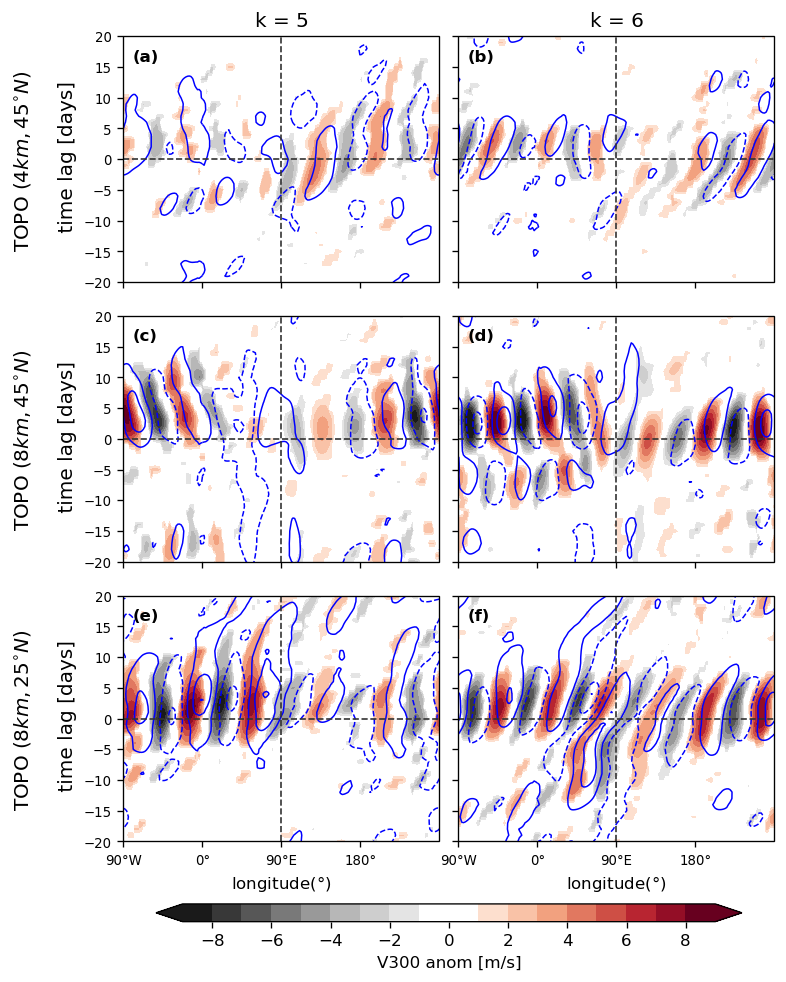

In [16]:
#zonal mean plot
import cartopy.crs as ccrs
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmaps 
import string

#select here for which wave number you want to do the plot

# wavenumbers 5 and 6(Figure 4)
# wavenumbers 4 and 7 (Figure S6)
w=[5,6]

#Smoothing
import metpy.calc as mpcalc

#to make the plot larger
plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 7, 11.5

#Hovmuller diagram
f, axes = plt.subplots(3, 2, sharey=True, sharex=True, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=90.0, globe=None)))
axes = axes.flatten()

axes[0].set_ylabel('TOPO $(4km,45^{\circ} N)$ \n\n time lag [days]',fontsize=12)
axes[2].set_ylabel('TOPO $(8km,45^{\circ} N)$ \n\n time lag [days]',fontsize=12)
axes[4].set_ylabel('TOPO $(8km,25^{\circ} N)$ \n\n time lag [days]',fontsize=12)

nLons = np.arange(-180,180,90)

for ax in axes:
    ax.set_xticks(nLons, crs=ccrs.PlateCarree());
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.axhline(0, color='0.2', ls='--',lw=1.0)
    ax.axvline(0, color='0.2', ls='--',lw=1.0)
    ax.set_aspect(7)
    ax.set_facecolor('0.6')
    #set plot limits
    #ax.set_xlim(0,360)
    ax.set_xticks(np.arange(-180,180,90))
    ax.set_yticks(np.arange(-20,21,5))
    ax.set_ylim(-20,20)
    #ax.scatter(0,0, s=50, c='0.6', marker="o",zorder=10)
    
    # format the ticks as e.g 60°W
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    
axes[4].set_xlabel('longitude($\degree$)')
axes[5].set_xlabel('longitude($\degree$)')

#contour plot
lev1 = np.arange(-9,9.1,1.0) #v300
norm1 = colors.BoundaryNorm(boundaries=lev1, ncolors=256)

lev2 = [-4,-3,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,4] #temperature
cmap2 = cmaps.BlueWhiteOrangeRed
norm2 = colors.BoundaryNorm(boundaries=lev2, ncolors=256)

lev3 = [18,20,22]

lag= v_anom_comp.lag
lon = v_anom_comp.lon

colors = mpl.cm.get_cmap('RdGy_r', 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
#middle 256/2=128
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

axes[0].set_title(f'k = {w[0]}',fontsize=12)
axes[1].set_title(f'k = {w[1]}',fontsize=12)
for j,sim in enumerate(range(1,4)):
    for i,wn in enumerate(w):
        #small smoothing (for easier visualization)
        t_plot = mpcalc.smooth_rectangular(t_anom_comp.sel(sim=sim,wn=wn), (3, 5), 1)
        v_plot = mpcalc.smooth_rectangular(v_anom_comp.sel(sim=sim,wn=wn), (3, 5), 1)

        DATA, LON = cutil.add_cyclic_point(v_anom_comp_p.sel(sim=sim,wn=wn),v_plot.lon)
        h1 =  axes[j*2+i].contourf(LON, lag, DATA, cmap=newcmap, extend='both', alpha=1.0,transform=ccrs.PlateCarree())
        v_plot = xr.where(v_anom_comp_p.sel(sim=sim,wn=wn)<0.05, v_plot, 0.0)
        DATA, LON = cutil.add_cyclic_point(v_plot ,v_plot.lon)
        h1 =  axes[j*2+i].contourf(LON, lag, DATA, levels=lev1, norm=norm1,cmap=newcmap, extend='both', alpha=1.0,transform=ccrs.PlateCarree())
        
        DATA, LON = cutil.add_cyclic_point(t_plot ,t_plot.lon)
        h2 = axes[j*2+i].contour(LON, lag, DATA, levels=[-2,-1.5,-0.5,0.5,1.5,2.5], colors='blue',linewidths=0.9, transform=ccrs.PlateCarree())

for i,ax in enumerate(axes):
    tx = ax.text(-170, 16, '(' + string.ascii_lowercase[i] + ')', color='k', size=10, weight='bold')
        
f.subplots_adjust(hspace=0.06, wspace=0.06)
cb1 = plt.colorbar(h1,ax=axes, label='V300 anom [m/s]',pad=0.06,orientation='horizontal',shrink=0.9,aspect=30) 


plt.savefig(f'figures/hovmoller_k={w[0]},{w[1]}_ICON_pannel_high_amplitude_events_1.5SD_3daysmin_significatce_pval=0.05.pdf',bbox_inches='tight')

# Figure S7: climatology background

In [27]:
wn, lon = amp_mnt.wn, v_anom.lon
nlag=30
lags =np.arange(-nlag,nlag+1,1)
sim =[0,1,2,3]

v_clim_comp = xr.DataArray(coords=[sim, wn, lags, lon],
                           dims=['sim','wn', 'lag', 'lon'])
t_clim_comp = xr.DataArray(coords=[sim, wn, lags, lon],
                           dims=['sim','wn', 'lag', 'lon'])

for sim in range(1,4):
    for i,wn in enumerate(onset_dates.wn):    
    	for k,lag in enumerate(lags):
        	v_clim_comp[sim,i,k,:] = v_mnt[sim,:,:].mean('time')
        	t_clim_comp[sim,i,k,:] = t_mnt[sim,:,:].mean('time')  

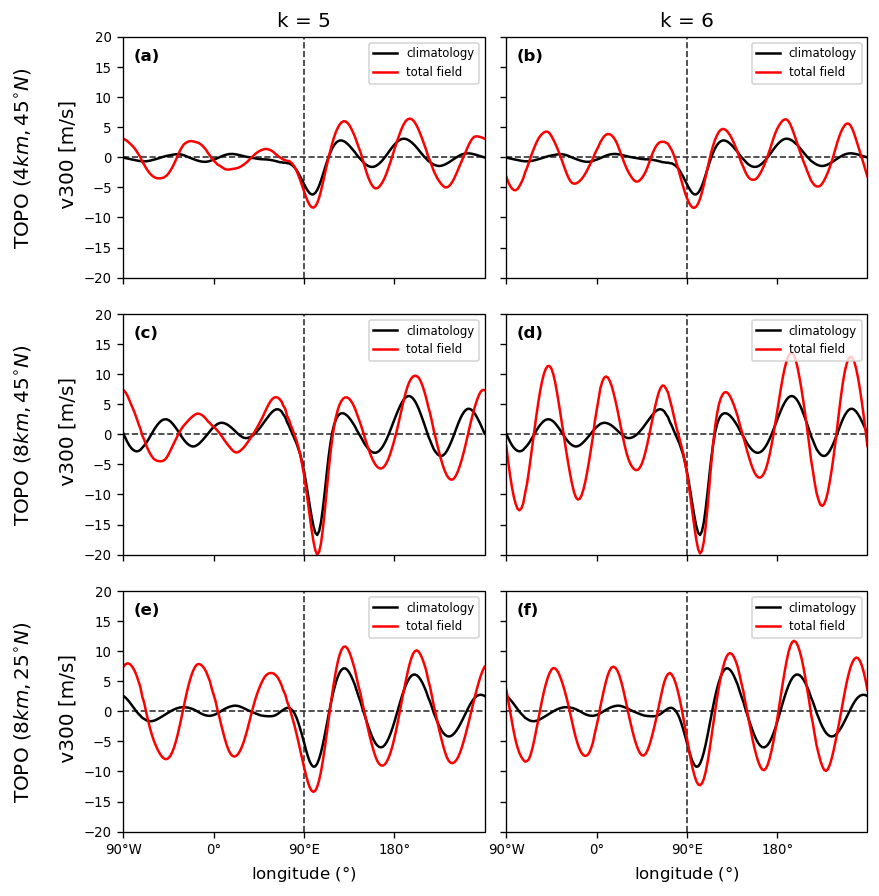

In [29]:
#line plots
import cartopy.crs as ccrs
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmaps 
import string


w=[5,6]

#Smoothing
import metpy.calc as mpcalc

#to make the plot larger
plt.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = 8, 9

#Hovmuller diagram
f, axes = plt.subplots(3, 2, sharey=True, sharex=True, subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=90.0, globe=None)))
axes = axes.flatten()

axes[0].set_ylabel('TOPO $(4km,45^{\circ} N)$ \n\n v300 [m/s]',fontsize=12)
axes[2].set_ylabel('TOPO $(8km,45^{\circ} N)$ \n\n v300 [m/s]',fontsize=12)
axes[4].set_ylabel('TOPO $(8km,25^{\circ} N)$ \n\n v300 [m/s]',fontsize=12)

nLons = np.arange(-180,180,90)

for ax in axes:
    ax.set_xticks(nLons, crs=ccrs.PlateCarree());
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.axhline(0, color='0.2', ls='--',lw=1.0)
    ax.axvline(0, color='0.2', ls='--',lw=1.0)
    ax.set_aspect(6)
    #set plot limits
    ax.set_xticks(np.arange(-180,180,90))
    ax.set_yticks(np.arange(-20,21,5))
    ax.set_ylim(-20,20)

    # format the ticks as e.g 60°W
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    
axes[4].set_xlabel('longitude ($\degree$)')
axes[5].set_xlabel('longitude ($\degree$)')

lon = v_anom_comp.lon

axes[0].set_title(f'k = {w[0]}',fontsize=12)
axes[1].set_title(f'k = {w[1]}',fontsize=12)

for j,sim in enumerate(range(1,4)):
    for i,wn in enumerate(w):
        v_plot = v_clim_comp.sel(sim=sim, wn=wn, lag=slice(0,5)).mean('lag')
        v_plot2 = v_plot + v_anom_comp.sel(sim=sim,wn=wn,lag=slice(0,5)).mean('lag')
        
        DATA, LON = cutil.add_cyclic_point(v_plot ,v_plot.lon)
        h1 = axes[j*2+i].plot(LON, DATA, color='k', transform=ccrs.PlateCarree(), label= 'climatology')
        DATA, LON = cutil.add_cyclic_point(v_plot2 ,v_plot2.lon)
        h2 = axes[j*2+i].plot(LON, DATA, color='red', transform=ccrs.PlateCarree(), label = 'total field')
        
for i,ax in enumerate(axes):
    tx = ax.text(-170, 16, '(' + string.ascii_lowercase[i] + ')', color='k', size=10, weight='bold')
    ax.legend(loc=1, fontsize=7)
        
f.subplots_adjust(hspace=0.06, wspace=0.06)

plt.savefig(f'figures/total_field_vs_clim_k={w[0]},{w[1]}_ICON_pannel_high_amplitude_events_1.5SD_3daysmin_lag0-5.pdf',bbox_inches='tight')

# Figure S9 (duration histogram)

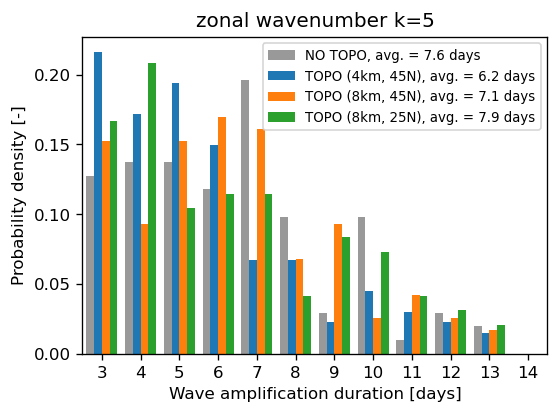

In [37]:
import matplotlib.pyplot as plt

#change wavenumber here
k=5
mpl.rcParams['figure.figsize'] = 5,3.5

#Histograms
f, ax = plt.subplots(1,1, sharex=True)

colors = ['0.6', 'C0', 'C1','C2']
x= duration[:,0:4,:].sel(wn=k).values

labels = ('NO TOPO, avg. = {:.1f} days'.format(np.nanmean(x[:,0])),
          'TOPO (4km, 45N), avg. = {:.1f} days'.format(np.nanmean(x[:,1])),
          'TOPO (8km, 45N), avg. = {:.1f} days'.format(np.nanmean(x[:,2])),
          'TOPO (8km, 25N), avg. = {:.1f} days'.format(np.nanmean(x[:,3])))
n_bins= np.arange(2.5,14.5,1.0)

#plt.bar(x, height, width=0.8, bottom=None, align='center', data=None, **kwargs)[source]

ax.hist(x, n_bins, density=True, histtype='bar', color=colors, label=labels)
#ax.hist(x, n_bins)
#set plot limits
ax.set_xlim(2.5,14.5)
ax.set_xticks([3,4,5,6,7,8,9,10,11,12,13,14])

#adding a legend
ax.legend(fontsize=8,loc='upper right')

ax.set_title('zonal wavenumber k='+str(k))
ax.set_ylabel('Probability density [-]')
ax.set_xlabel('Wave amplification duration [days]')


plt.savefig('figures/hist_duration_k='+str(k)+'_amplitude_events_1.5SD_3daysmin.pdf',bbox_inches='tight')
#ax.axvline(5.5, color='0.2', ls="--", lw=1.5)